<a href="https://colab.research.google.com/github/JosephMuddle/CA-Transformer/blob/main/pytorch_ca_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
import math
import json
from functools import partial
import jax

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
!pip install --quiet pytorch-lightning>=1.4
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
CHECKPOINT_PATH = '/content/drive/MyDrive/Transformer_for_CA'
DATASET_PATH = '/content/drive/MyDrive/Transformer_for_CA/CA_data'


from google.colab import drive
drive.mount('/content/drive')

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-2-c212c16a1954>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda:0


<Figure size 640x480 with 0 Axes>

#Cellular Automata

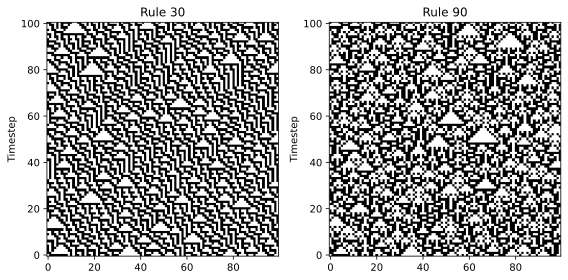

In [ ]:
rule30 = np.array([0, 1, 1, 1, 1, 0, 0, 0], dtype=float)
rule90 = np.array([0,1,0,1,1,0,1,0], dtype=float)
rule105 = np.array([0, 1, 1, 0, 1, 0, 0, 1], dtype=float)

def apply_rule(state, rule):
    new = np.zeros(len(state))
    for i in range(0,len(state)):
        new[i] = (rule[int(state[i-1]*4) + int(state[i]*2) + int(state[(i+1)%len(state)])]) #binary indexing into the rule
    return new

def evolve(rule, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]

    for _ in range(steps):
        state = apply_rule(state, rule)
        history.append(state.copy())

    return history


initial_state = np.random.randint(0,2, 100,dtype=int)
initial_state[50] = 1
steps = 100
evolution_history_rule30 = evolve(rule30, initial_state, steps)
evolution_history_rule90 = evolve(rule90, initial_state, steps)
fig_combined, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(evolution_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[0].set_title("Rule 30")
axes[0].set_ylabel("Timestep")

axes[1].imshow(evolution_history_rule90, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[1].set_title("Rule 90")
axes[1].set_ylabel("Timestep")

plt.tight_layout()
plt.show()

#Transformer architecture
First, I implement a form of attention using ALIBI, such that more attention is paid to those elements in a sequence closer to the element being observed

In [ ]:
def get_alibi_slopes(num_heads: int):
    def get_slopes_power_of_2(n):
        x = lambda i : (2 ** 8) ** (1 / i)
        return np.array([x(i) for i in range(1, n+1)])

    if num_heads == 1:  # Handle the case where num_heads is 1 directly
        return get_slopes_power_of_2(1)
    elif num_heads % 2 == 0:
        slopes = get_slopes_power_of_2(num_heads)
    else:
        slopes = get_slopes_power_of_2(num_heads - 1)
        slopes = np.concatenate([slopes, slopes[-1:]])
    return slopes

def compute_wrap_around_distance(a, b):
    # Compute absolute difference
    seq_length = a.shape[0]
    abs_diff = np.abs(a - b)
    # Compute wrap-around distance
    wrap_diff = np.minimum(abs_diff, abs(seq_length - abs_diff))
    return wrap_diff

In [ ]:
def scaled_dot_product(k, q, v, mask=None, alibi_slopes=None):
    d_k = q.shape[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    if alibi_slopes is not None:
        batch_size, num_heads, q_seq_length, _ = q.shape
        _, _, k_seq_length, _ = k.shape

        i = torch.arange(q_seq_length)[:, None]
        j = torch.arange(k_seq_length)[None, :]
        distance = compute_wrap_around_distance(i, j)
        distance += 1

        # Reshape slopes to (1, num_heads, 1, 1) for broadcasting
        alibi_slopes = alibi_slopes.reshape(1, num_heads, 1, 1)
        alibi_matrix = alibi_slopes / distance  # shape (1, num_heads, q_seq_length, k_seq_length)
        #print(alibi_matrix)
        alibi_matrix = alibi_matrix.to(device)
        attn_logits = attn_logits + (0.01 * alibi_matrix)

    if mask is not None:  # Apply masking *after* ALiBi
        attn_logits = attn_logits.masked_fill(mask == 0, -1e9) # More torch-idiomatic masking

    v = v.float()
    attention = F.softmax(attn_logits, dim=-1)
    attention = attention.float()
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
"""testing that everything matches up"""

batch_size = 1
num_heads = 1
q_seq_length = 5
k_seq_length = 5
d_k = 2

# Dummy k, q, v (random values for demonstration)
key_dummy = torch.randn(batch_size, num_heads, k_seq_length, d_k, dtype=torch.float64).to(device)
query_dummy = torch.randn(batch_size, num_heads, q_seq_length, d_k, dtype=torch.float64).to(device)
value_dummy = torch.randn(batch_size, num_heads, k_seq_length, d_k, dtype=torch.float64).to(device)
# Calculate ALiBi slopes
alibi_slopes_dummy = get_alibi_slopes(num_heads)

# --- Run the function and print ALiBi matrix ---
values_output, attention_output = scaled_dot_product(
    k=key_dummy,
    q=query_dummy,
    v=value_dummy,
    alibi_slopes=alibi_slopes_dummy
)

print("\nAttention Output Shape:", attention_output.shape)
print("Values Output Shape:", values_output.shape)


Attention Output Shape: torch.Size([1, 1, 5, 5])
Values Output Shape: torch.Size([1, 1, 5, 2])


In [ ]:
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [ ]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self.alibi_slopes = get_alibi_slopes(self.num_heads)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)                    #I dont really understand
        nn.init.xavier_uniform_(self.o_proj.weight)         #the use of filling biases with 0s
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask, alibi_slopes = self.alibi_slopes)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [458]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0, dim_feedforward = 512):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.dim_feedforward = dim_feedforward
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=self.dim_feedforward,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, 1) #output dim of 1 as we are binary classifying
        )

        self.outsig = nn.Sigmoid()

    def forward(self, x, mask=None):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        #print(x)
        x = self.input_net(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=self.hparams.lr)

        return optimizer

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data)
        loss = F.binary_cross_entropy_with_logits(preds, labels, reduction='sum')
        acc = ((self.outsig(preds) >= 0.5) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log(f"{mode}_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        return loss, acc

In [459]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "CATask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    model = TransformerPredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [460]:
#proof of concept dataset (only 1 step CA transformation)
class CellularAutomataDataset_1step(data.Dataset):
    def __init__(self, num_samples, state_length, rule):
        self.num_samples = num_samples
        self.state_length = state_length
        self.rule = rule

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        initial_state = np.random.randint(0, 2, size=self.state_length)
        next_state = apply_rule(initial_state, self.rule)
        return torch.from_numpy(initial_state.astype(np.float32)).unsqueeze(-1), torch.from_numpy(next_state.astype(np.float32)).unsqueeze(-1)

In [489]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return torch.from_numpy(np.stack(batch))
    else:
        return torch.from_numpy(np.array(batch))

rule30_dataset = partial(CellularAutomataDataset_1step, state_length=6, rule=rule30)  # rule is included
train_loader = data.DataLoader(rule30_dataset(12000),
                                   batch_size=64)
val_loader   = data.DataLoader(rule30_dataset(500),
                                   batch_size=64)
test_loader  = data.DataLoader(rule30_dataset(100),
                                   batch_size=64)

In [490]:
reverse_model, reverse_result = train_reverse(
                                              input_dim=1,
                                              model_dim=64,
                                              num_heads=8,
                                              num_classes=1,
                                              num_layers=6,
                                              dropout=0.1,
                                              lr=1e-4,
                                              warmup=50,
                                              dim_feedforward = 2048)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | input_net   | Sequential         | 128    | train
1 | transformer | TransformerEncoder | 1.7 M  | train
2 | output_net  | Sequential         | 4.4 K  | train
3 | outsig      | Sigmoid            | 0      | train
-----------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.766     Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [484]:
print(reverse_result)

{'test_acc': 0.8774999976158142, 'val_acc': 0.8748999834060669}


In [487]:
def evolve_neural(model, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]
    model.eval()

    with torch.no_grad():
        for _ in range(steps):

            #making it suitable for model input
            state = np.expand_dims(state, axis=[-1,0]).astype(np.float32)
            state = torch.from_numpy(state).to(device)
            state = model(state)
            state = model.outsig(state)

            state = state.cpu().detach().numpy()
            state = np.squeeze(state)
            #state = (state >= 0.5).astype(int)
            #print(state)
            history.append(state)
    return history

def evolve(rule, initial_state, steps):
    state = initial_state.copy()
    history = [state.copy()]

    for _ in range(steps):
        state = apply_rule(state, rule)
        history.append(state.copy())

    return history

    return history
def plot_evolution(history):
    plt.figure(figsize=(5, 5))
    plt.imshow(history, cmap="binary", interpolation="nearest", origin="lower")
    plt.show()

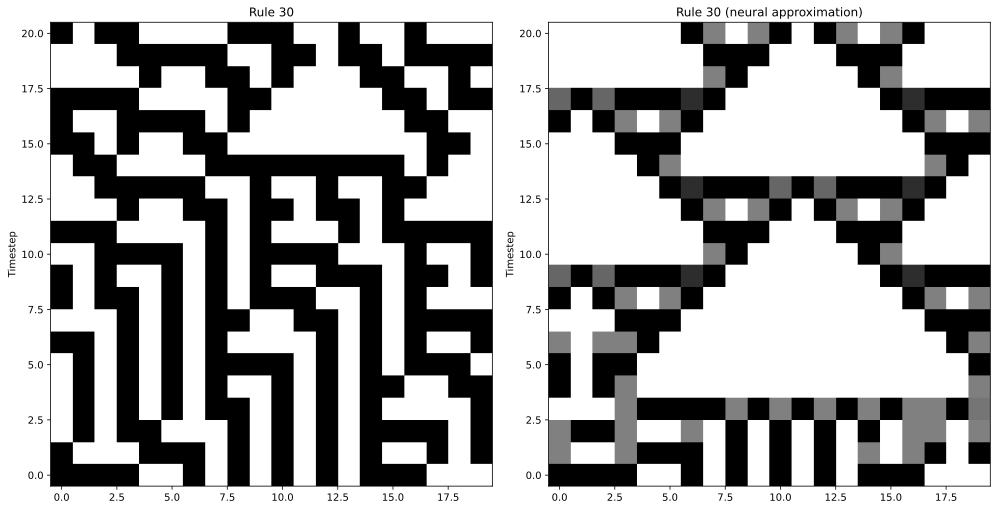

In [488]:
initial_state = np.random.randint(0, 2, size=20)
steps = 20
evolution_history_rule30 = evolve(rule30, initial_state, steps)
neural_history_rule30 = evolve_neural(reverse_model, initial_state, steps)
fig_combined, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(evolution_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[0].set_title("Rule 30")
axes[0].set_ylabel("Timestep")

axes[1].imshow(neural_history_rule30, cmap="binary", interpolation="nearest", origin="lower") # Get the image data
axes[1].set_title("Rule 30 (neural approximation)")
axes[1].set_ylabel("Timestep")

plt.tight_layout()
plt.show()